
## Fitting a linear regression model with TF Eager

**Goal:** In this notebook you will see how to use TF Eager to fit the parameters (slope and intercept) of a simple linear regression model via gradient descent (GD). 

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Dataset:** You work again with the systolic blood pressure and age data of 33 American women, which is generated and visualized in the upper part of the notebook.

**Content:**

* fit a linear model via the sklearn machine learning library of python to get the fitted values of the intercept and slope as reference. 

* use the tensorflow library and enable the tf eager mode to fit the parameters of the simple linear model via GD with the objective to minimize the MSE loss. 
    * define the mse loss function 
    * apply the gradients_function of tf eager on the loss w.r.t. the parameters
    * use the gradients to update the parameter values via update formula
    * iterate over the two former steps for many steps and check the current values of the estimated model parameters and the loss after each updatestep 
    * verify that the estimated parameter values converge to the values which you got from the sklearn fit.  


[open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_03/nb_ch03_06.ipynb)

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0 
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.linear_model import LinearRegression

Here we read in the systolic blood pressure and the age of the 33 American women in our dataset. Then we use the sklearn library to find the optimal values for the slope a and the intercept b.

In [3]:
# Blood Pressure data
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9, 
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114, 
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217] 
x = np.asarray(x, np.float32) 
y = np.asarray(y, np.float32)

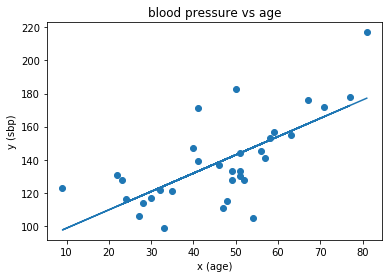

intercept =  87.67143 solpe =  1.1050216


In [4]:
plt.scatter(x=x,y=y)
plt.title("blood pressure vs age")
plt.xlabel("x (age)")
plt.ylabel("y (sbp)")

model = LinearRegression()
res = model.fit(x.reshape((len(x),1)), y)
predictions = model.predict(x.reshape((len(x),1)))
plt.plot(x, predictions)
plt.show()
print("intercept = ",res.intercept_,"solpe = ", res.coef_[0],)

## TF Eager

Now we want to use the TF Eager mode to find the optimal parameters for the linear regression problem. First we define our mse loss function.

In [5]:
def loss(a, b):
  y_hat = a*x + b
  return tf.reduce_mean((y_hat - y)**2)

We can do a forwad pass and can calculate the loss (mse) with the initial values a=0 and b=139 (139 is the mean of the blood pressure and slope a=0 implies that the model predicts the mean for each age). Note that `a` and `b` must be `tf.Variables`. We see the loss value in the numpy argument in the output. In contrast to old (pre 2.0) TensorFlow we don't need to run a session to get loss!

In [6]:
a = tf.Variable(0.0)
b = tf.Variable(139.0)
loss(a,b)

<tf.Tensor: id=25, shape=(), dtype=float32, numpy=673.4545>

Now we define that we want to have the gradients of the loss w.r.t to our two model parameters, the slope `a` and the intercept `b`. In the next cell we print the gradient of the loss w.r.t `a` and gradient of the loss w.r.t to `b`. Note that we calculated the loss for all data points and therefore we get different gradients compared to nb_04, where we only used one datapoint. To be able to calculate the gradient of the loss, we must store the itermediate values needed for calculating the gradients in an object called tape.

In [7]:
a = tf.Variable(0.0)
b = tf.Variable(139.0)
with tf.GradientTape() as tape:
  loss_val = loss(a,b)
  print("Loss at ", loss_val)
  grad_a, grad_b = tape.gradient(loss_val, [a,b])
  print(grad_a, grad_b)

Loss at  tf.Tensor(673.4545, shape=(), dtype=float32)
tf.Tensor(-553.09094, shape=(), dtype=float32) tf.Tensor(0.727273, shape=(), dtype=float32)


Now, let's use gradient descent to opimize the slope a and the intercept b. The start values are a=0 and b=139, our learning rate eta is 0.0004 and we do 80000 updatesteps with all 33 observations. 

In [8]:
from time import time
a  = tf.Variable(0.) 
b = tf.Variable(139.0) 
eta = 0.0004  
start= time()
for i in range(80000): 
  with tf.GradientTape() as tape: 
    y_hat = a*x + b  
    loss = tf.reduce_mean((y_hat - y)**2) 
    grad_a, grad_b  = tape.gradient(loss, [a,b]) 
    a = tf.Variable(a - eta * grad_a) 
    b = tf.Variable(b - eta * grad_b) 
    if (i % 5000 == 0): 
        t = time() - start
        print("Epoch:",i, "slope=",a.numpy(),"intercept=",b.numpy(),"gradient_a", grad_a.numpy(), "gradient_b",grad_b.numpy(), "mse=", loss.numpy(), "time for 1000 epochs ", t/5.)
        start = time()
      


Epoch: 0 slope= 0.22123638 intercept= 138.99971 gradient_a -553.09094 gradient_b 0.727273 mse= 673.4545 time for 1000 epochs  0.0006892204284667969
Epoch: 5000 slope= 0.47009143 intercept= 120.60784 gradient_a -0.14053345 gradient_b 7.3059855 mse= 469.57272 time for 1000 epochs  2.417998027801514
Epoch: 10000 slope= 0.6975813 intercept= 108.807014 gradient_a -0.09031677 gradient_b 4.688313 mse= 398.76877 time for 1000 epochs  2.401115131378174
Epoch: 15000 slope= 0.8435634 intercept= 101.23433 gradient_a -0.058013916 gradient_b 3.0085347 mse= 369.61255 time for 1000 epochs  2.465251398086548
Epoch: 20000 slope= 0.9372412 intercept= 96.37488 gradient_a -0.036483765 gradient_b 1.9306204 mse= 357.6062 time for 1000 epochs  3.0992573261260987
Epoch: 25000 slope= 0.99735403 intercept= 93.256584 gradient_a -0.023651123 gradient_b 1.2389097 mse= 352.66214 time for 1000 epochs  2.6289466381073
Epoch: 30000 slope= 1.0359306 intercept= 91.25547 gradient_a -0.016540527 gradient_b 0.7949929 mse= 3

Let's look at the final values for the slope a,the intercept b and the mse loss. We know form the closed formula solution that:

1.   optimal value for a: 1.1050216
2.   optimal value for b: 87.67143
3.   minimal loss: 349.200787168560

After 80000 update steps we are very close to the optimal values






In [9]:
print(a.numpy(), b.numpy(), loss.numpy())

1.1041987 87.71413 349.20105


### Making it faster with tf.function

Eager is really great when you start building a network from scratch. You can use debugging and immediately spot problems as they occur. You don't have to compile a graph first and then run it. 

However, if you use many small operations this might become slow. A way to speed this up, is the use of the `@tf.function` decorator. See https://www.tensorflow.org/guide/function for more details. 

In [10]:
start= time()
a  = tf.Variable(0.0)
b = tf.Variable(139.0)
eta = 0.0004

@tf.function #Will tell tf to build a graph from this code
def train_step():
    y_hat = a*x + b
    loss = tf.reduce_mean((y_hat - y)**2)   
    grad_a, grad_b  = tape.gradient(loss, [a,b])
    a.assign(a - eta * grad_a)
    b.assign(b - eta * grad_b)

for i in range(80000):
  with tf.GradientTape() as tape: #Record the gradients from now on
    train_step()
    if (i % 5000 == 0):
        t = time() - start
        print("Epoch:",i, "slope=",a.numpy(),"intercept=",b.numpy(),"gradient_a", grad_a.numpy(), "gradient_b",grad_b.numpy(), "mse=", loss.numpy(), "time for 1000 epochs ", t/5.)
        start = time()
        

Epoch: 0 slope= 0.22123638 intercept= 138.99971 gradient_a -0.00093078613 gradient_b 0.009457111 mse= 349.20105 time for 1000 epochs  0.024369335174560545
Epoch: 5000 slope= 0.47009143 intercept= 120.60784 gradient_a -0.00093078613 gradient_b 0.009457111 mse= 349.20105 time for 1000 epochs  0.26144886016845703
Epoch: 10000 slope= 0.6975813 intercept= 108.807014 gradient_a -0.00093078613 gradient_b 0.009457111 mse= 349.20105 time for 1000 epochs  0.25389609336853025
Epoch: 15000 slope= 0.8435634 intercept= 101.23433 gradient_a -0.00093078613 gradient_b 0.009457111 mse= 349.20105 time for 1000 epochs  0.25403523445129395
Epoch: 20000 slope= 0.9372412 intercept= 96.37488 gradient_a -0.00093078613 gradient_b 0.009457111 mse= 349.20105 time for 1000 epochs  0.2569833755493164
Epoch: 25000 slope= 0.99735403 intercept= 93.256584 gradient_a -0.00093078613 gradient_b 0.009457111 mse= 349.20105 time for 1000 epochs  0.2565422058105469
Epoch: 30000 slope= 1.0359306 intercept= 91.25547 gradient_a 